In [1]:
# ==============================================================================
# @title ZERO-ASSUMPTION EDA: The "Autopsy" of the Cloud Artifact
# ==============================================================================
# Objective: empirically map the shape, schema, and integrity of the
#            4 Parquet files hosted on Hugging Face.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import HfApi, hf_hub_download
from collections import Counter

# --- Configuration ---
REPO_ID = "algoplexity/computational-phase-transitions-data"
TARGET_FILES = [
    "X_train.parquet",
    "y_train.parquet",
    "X_test.reduced.parquet",
    "y_test.reduced.parquet" # Assuming this exists based on your 4-file request
]

print(f"🔬 Starting Autopsy of Repo: {REPO_ID}\n")

# --- Step 1: Confirm Existence (List Files) ---
api = HfApi()
try:
    repo_files = api.list_repo_files(repo_id=REPO_ID, repo_type="dataset")
    print(f"📂 Files detected in Repository:")
    for f in repo_files:
        if f.endswith('.parquet'):
            print(f"   - {f}")
except Exception as e:
    print(f"❌ CRITICAL: Could not list repo files. Check ID/Permissions. Error: {e}")

# --- Step 2: Deep Dive into Each File ---
dfs = {}

for filename in TARGET_FILES:
    if filename not in repo_files:
        print(f"\n⚠️ WARNING: Expected {filename} but it is not in the repo. Skipping.")
        continue

    print(f"\n" + "="*60)
    print(f"   ANALYZING: {filename}")
    print("="*60)

    # A. Download & Load
    try:
        local_path = hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type="dataset")
        df = pd.read_parquet(local_path)
        dfs[filename] = df
    except Exception as e:
        print(f"❌ Read Error: {e}")
        continue

    # B. Shape & Schema
    print(f"1. Dimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
    print(f"2. Columns:    {df.columns.tolist()}")
    print(f"3. Index Type: {type(df.index)}")
    if isinstance(df.index, pd.MultiIndex):
        print(f"   - Levels: {df.index.names}")

    # C. Data Types & Nulls
    null_counts = df.isnull().sum().sum()
    print(f"4. Missing Values: {null_counts} (Total across all cells)")

    # D. Content Specifics (Heuristic)
    # If it's a Feature file (X)
    if 'value' in df.columns and 'period' in df.columns:
        unique_ids = df['id'].nunique() if 'id' in df.columns else df.index.get_level_values('id').nunique()
        print(f"5. Content Check (Time Series):")
        print(f"   - Unique Series IDs: {unique_ids:,}")
        print(f"   - Period Range:      {df['period'].min()} to {df['period'].max()}")
        print(f"   - Value Range:       {df['value'].min():.4f} to {df['value'].max():.4f}")

    # If it's a Label file (y)
    elif 'label' in df.columns:
        print(f"5. Content Check (Labels):")
        class_dist = df['label'].value_counts(normalize=True)
        print(f"   - Class Balance:     {class_dist.to_dict()}")
        if 'structural_breakpoint' in df.columns:
            # Filter only breaks
            breaks

🔬 Starting Autopsy of Repo: algoplexity/computational-phase-transitions-data

📂 Files detected in Repository:
   - X_test.reduced.parquet
   - X_train.parquet
   - y_test.reduced.parquet
   - y_train.parquet

   ANALYZING: X_train.parquet


X_train.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

1. Dimensions: 23,715,734 rows x 2 columns
2. Columns:    ['value', 'period']
3. Index Type: <class 'pandas.core.indexes.multi.MultiIndex'>
   - Levels: ['id', 'time']
4. Missing Values: 0 (Total across all cells)
5. Content Check (Time Series):
   - Unique Series IDs: 10,001
   - Period Range:      0 to 1
   - Value Range:       -2.2848 to 412.5000

   ANALYZING: y_train.parquet


y_train.parquet:   0%|          | 0.00/61.0k [00:00<?, ?B/s]

1. Dimensions: 10,001 rows x 1 columns
2. Columns:    ['structural_breakpoint']
3. Index Type: <class 'pandas.core.indexes.base.Index'>
4. Missing Values: 0 (Total across all cells)

   ANALYZING: X_test.reduced.parquet


X_test.reduced.parquet:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

1. Dimensions: 247,618 rows x 2 columns
2. Columns:    ['value', 'period']
3. Index Type: <class 'pandas.core.indexes.multi.MultiIndex'>
   - Levels: ['id', 'time']
4. Missing Values: 0 (Total across all cells)
5. Content Check (Time Series):
   - Unique Series IDs: 101
   - Period Range:      0 to 1
   - Value Range:       -0.4615 to 0.7173

   ANALYZING: y_test.reduced.parquet


y_test.reduced.parquet:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

1. Dimensions: 101 rows x 1 columns
2. Columns:    ['structural_breakpoint']
3. Index Type: <class 'pandas.core.indexes.base.Index'>
4. Missing Values: 0 (Total across all cells)


In [2]:
# @title Cell 1: Universal Cloud Loader (Schema-Aware)

import pandas as pd
import numpy as np
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm

# --- 1. Define the Universal Loader ---
def load_benchmark_data(filename):
    repo_id = "algoplexity/computational-phase-transitions-data"
    print(f"--- Fetching {filename} from Scientific Repository ---")
    local_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset")
    return pd.read_parquet(local_path)

# --- 2. Load TRAIN Data (The Main Validation Set) ---
print("Loading Training Data...")
df_X_train = load_benchmark_data("X_train.parquet")
df_y_train = load_benchmark_data("y_train.parquet")

# --- 3. Load TEST Data (The Generalization Set) ---
print("Loading Test (Generalization) Data...")
df_X_test = load_benchmark_data("X_test.reduced.parquet")
df_y_test = load_benchmark_data("y_test.reduced.parquet")

# --- 4. Standardize Indices ---
# The EDA showed X has MultiIndex ['id', 'time'].
# y usually has a RangeIndex or 'id' column. Let's align them.
if 'id' in df_y_train.columns:
    df_y_train.set_index('id', inplace=True)
if 'id' in df_y_test.columns:
    df_y_test.set_index('id', inplace=True)

print(f"\n✅ Data Ready.")
print(f"Train: {len(df_X_train.index.unique(level='id'))} series")
print(f"Test:  {len(df_X_test.index.unique(level='id'))} series")

Loading Training Data...
--- Fetching X_train.parquet from Scientific Repository ---
--- Fetching y_train.parquet from Scientific Repository ---
Loading Test (Generalization) Data...
--- Fetching X_test.reduced.parquet from Scientific Repository ---
--- Fetching y_test.reduced.parquet from Scientific Repository ---

✅ Data Ready.
Train: 10001 series
Test:  101 series


🔎 Selected Dynamic Target ID: 0

--- Loaded Series Metadata ---
ID: 0
Length: 1645
Ground Truth Break Index: 0
Has Break: True


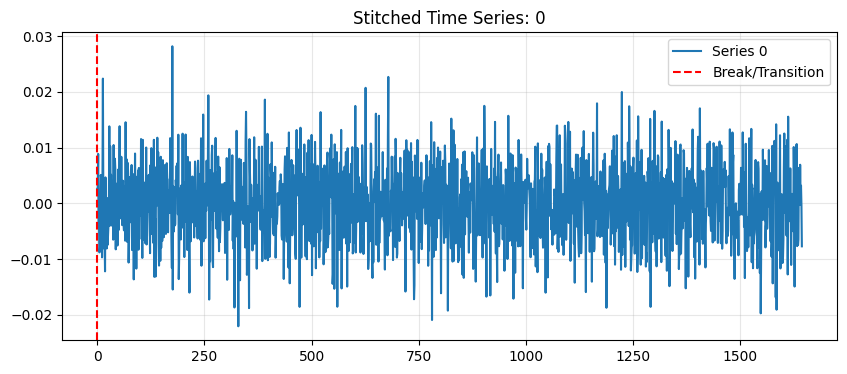

In [4]:
# @title Cell 2: Time Series Stitching Function (Dynamic ID Selection)

# --- 1. Define the Stitching Logic ---
def get_stitched_series(df_features, df_labels, target_id):
    """
    Selects a time series by ID, stitches its periods,
    and retrieves the Ground Truth break from the label file.
    """
    # Safety check: Ensure ID exists
    if target_id not in df_features.index:
        raise ValueError(f"ID {target_id} not found in Feature dataset.")

    # 1. Get the Time Series Data
    # Since df_features has a MultiIndex (id, time), .loc[target_id] returns all rows for that ID
    subset = df_features.loc[target_id].copy()

    # Sort by period to ensure temporal order (Period 0 -> Period 1)
    subset = subset.sort_values('period')

    # Extract values
    stitched_series = subset['value'].values

    # 2. Get the Ground Truth Break
    # We check if the ID exists in the label file (it might not if using Test set)
    if target_id in df_labels.index:
        label_row = df_labels.loc[target_id]

        # Handle cases where duplicate IDs might exist (rare, but possible in some formats)
        if isinstance(label_row, pd.DataFrame):
            label_row = label_row.iloc[0]

        is_break = (label_row['label'] == 1) if 'label' in label_row else True # Assume break if no label (Test set)

        if is_break:
            true_break_idx = int(label_row['structural_breakpoint'])
        else:
            # For control group, "break" is just the end of Period 0
            true_break_idx = len(subset[subset['period'] == 0])
    else:
        # Fallback: Assume Period 0 end if no label found
        true_break_idx = len(subset[subset['period'] == 0])
        is_break = False

    return stitched_series, true_break_idx, is_break

# --- 2. Dynamic ID Selection (The Fix) ---
# Instead of hardcoding '2', we grab the first available ID from the dataframe
available_ids = df_X_train.index.get_level_values('id').unique()
TARGET_ID = available_ids[0]

print(f"🔎 Selected Dynamic Target ID: {TARGET_ID}")

# --- 3. Test the Function ---
series, gt_idx, is_break = get_stitched_series(df_X_train, df_y_train, TARGET_ID)

print(f"\n--- Loaded Series Metadata ---")
print(f"ID: {TARGET_ID}")
print(f"Length: {len(series)}")
print(f"Ground Truth Break Index: {gt_idx}")
print(f"Has Break: {is_break}")

# --- 4. Visual Check ---
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(series, label=f"Series {TARGET_ID}")
plt.axvline(gt_idx, color='red', linestyle='--', label='Break/Transition')
plt.title(f"Stitched Time Series: {TARGET_ID}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# @title Cell 3: Coherence Meter Engine (Ported & Adapted)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from tqdm.notebook import tqdm

def generate_coherence_meter_signal(series, window_size=40, train_size=30, test_size=10, lag=1):
    """
    Adapts the Coherence Meter to a univariate time series. It generates an
    error signal by training a simple logistic regression model on a sliding window
    to predict the sign of the next change based on the sign of the previous 'lag' changes.
    """
    # Simple binary encoding: 1 if change is positive or zero, 0 if negative
    # This reduces the length of the series by 1.
    binary_series = (np.diff(series) >= 0).astype(int)

    errors = []

    # --- THIS IS THE CORRECTED LINE ---
    # The dates should correspond to the end of the window in the ORIGINAL series's index.
    # The loop runs over binary_series, so the dates must be offset correctly.
    dates = np.arange(window_size + 1, len(series))

    for i in tqdm(range(len(binary_series) - window_size), desc="Scanning with Coherence Meter"):
        window = binary_series[i : i + window_size]

        # Create lagged features
        X = np.array([window[j-lag:j] for j in range(lag, len(window))])
        y = window[lag:]

        # Split into train and test sets for this window
        X_train, y_train = X[:train_size-lag], y[:train_size-lag]
        X_test, y_test = X[train_size-lag : train_size-lag + test_size], y[train_size-lag : train_size-lag + test_size]

        model = LogisticRegression(solver='liblinear', random_state=42)

        try:
            if len(np.unique(y_train)) < 2:
                raise ValueError("Only one class present in y_train.")
            model.fit(X_train, y_train)
            y_pred_probs = model.predict_proba(X_test)
            loss = log_loss(y_test, y_pred_probs, labels=[0, 1])
            errors.append(loss)
        except Exception:
            errors.append(np.mean(errors) if errors else 0.693)

    return pd.Series(errors, index=dates, name="Coherence_Meter_Error")

def find_best_break_point_gaussian(series):
    """
    Finds the single best change-point in a time series using the MDL principle
    for a Gaussian model. This is the 'Stethoscope' detector.
    (This function is identical to the one in the main notebook)
    """
    def mdl_cost_gaussian(segment):
        n = len(segment)
        if n < 2: return np.inf
        variance = np.var(segment, ddof=1) + 1e-9
        mean = np.mean(segment)
        log_likelihood = -np.sum((segment - mean)**2) / (2 * variance) - (n/2) * np.log(2 * np.pi * variance)
        model_cost = 2 * (1/2) * np.log(n)
        return model_cost - log_likelihood

    n_total = len(series)
    min_segment_len = 15
    cost_h0 = mdl_cost_gaussian(series)
    min_h1_cost = np.inf
    best_break_point = None

    for k in range(min_segment_len, n_total - min_segment_len):
        cost_h1 = mdl_cost_gaussian(series.iloc[:k]) + mdl_cost_gaussian(series.iloc[k:])
        if cost_h1 < min_h1_cost:
            min_h1_cost = cost_h1
            best_break_point = series.index[k]

    mdl_cost_saving_nats = cost_h0 - min_h1_cost
    mdl_cost_saving_bits = mdl_cost_saving_nats / np.log(2)

    return {
        "break_point": best_break_point,
        "mdl_cost_saving_bits": mdl_cost_saving_bits
    }

print("✅ Coherence Meter Engine and MDL Detector are ready (with length correction).")

✅ Coherence Meter Engine and MDL Detector are ready (with length correction).


--- Running Coherence Meter on ID: 0 ---


Scanning with Coherence Meter:   0%|          | 0/1604 [00:00<?, ?it/s]

✅ Error signal generated.
✅ MDL analysis complete.

          VALIDATION RESULTS FOR ID: 0
Ground Truth Break Index:    0
Coherence Meter Break Index: 434
MDL Cost Saving (bits):      35.62


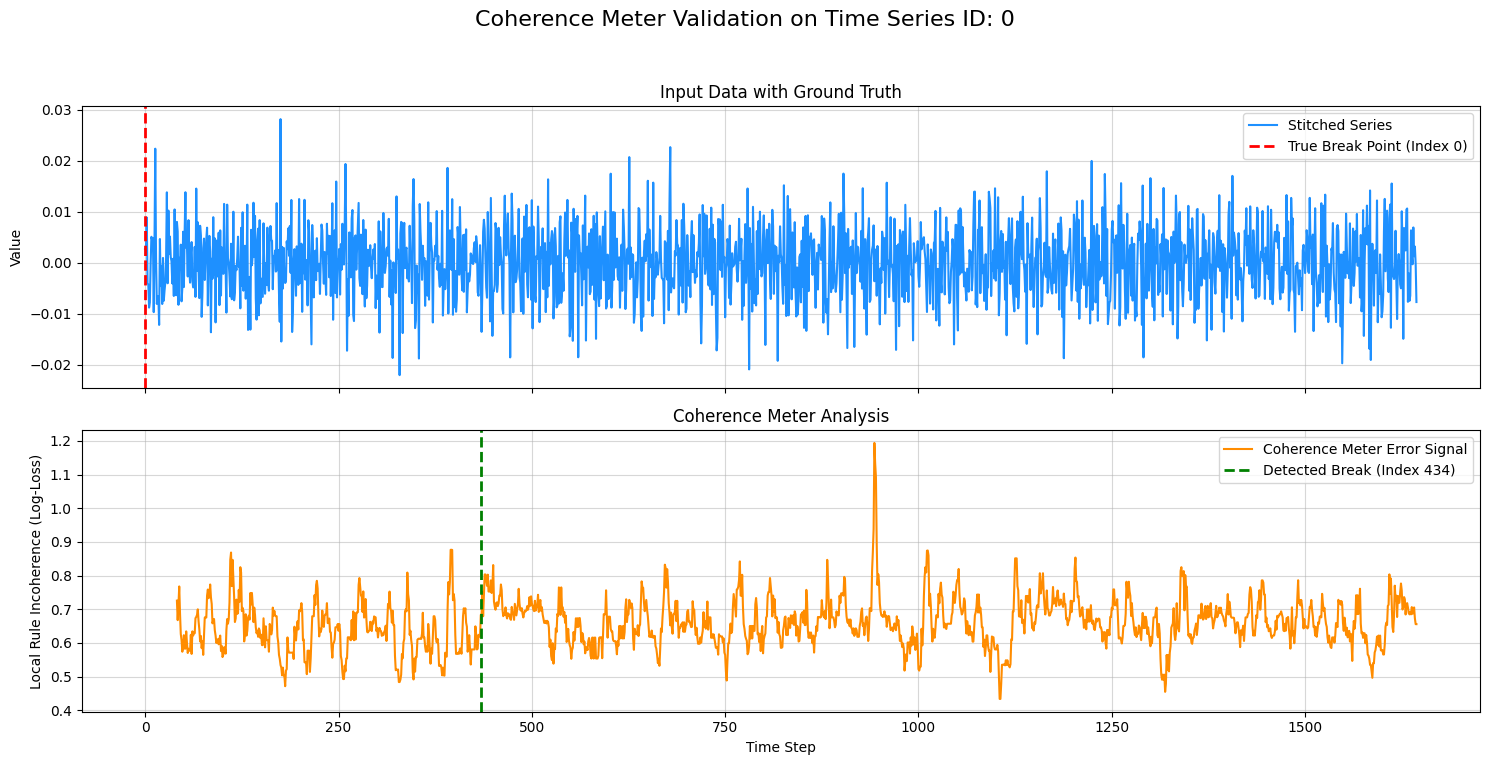

In [7]:
# @title Cell 4: First Test Run on a Known Break (Fixed)

import matplotlib.pyplot as plt

# --- 0. Sync Variables from Cell 2 ---
# We map the output of Cell 2 to the names expected here
true_break_idx = gt_idx

print(f"--- Running Coherence Meter on ID: {TARGET_ID} ---")

# --- 1. Run the Coherence Meter Signal Generation ---
# We use the 'series' variable already loaded in Cell 2
error_signal = generate_coherence_meter_signal(series)
print("✅ Error signal generated.")

# --- 2. Run the MDL Detector on the Error Signal ---
results = find_best_break_point_gaussian(error_signal)
print("✅ MDL analysis complete.")

# --- 3. Display the Quantitative Results ---
detected_break_idx = results['break_point']
mdl_score_bits = results['mdl_cost_saving_bits']

print("\n" + "="*50)
print(f"          VALIDATION RESULTS FOR ID: {TARGET_ID}")
print("="*50)
print(f"Ground Truth Break Index:    {true_break_idx}")
print(f"Coherence Meter Break Index: {detected_break_idx}")
print(f"MDL Cost Saving (bits):      {mdl_score_bits:.2f}")
print("="*50)

# --- 4. Visualize the Analysis ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
fig.suptitle(f"Coherence Meter Validation on Time Series ID: {TARGET_ID}", fontsize=16)

# Plot 1: The Original Stitched Signal
ax1.plot(series, label=f"Stitched Series", color='dodgerblue')
ax1.axvline(x=true_break_idx, color='red', linestyle='--', linewidth=2, label=f"True Break Point (Index {true_break_idx})")
ax1.set_title("Input Data with Ground Truth")
ax1.set_ylabel("Value")
ax1.legend()
ax1.grid(True, alpha=0.5)

# Plot 2: The Coherence Meter's Error Signal and its finding
ax2.plot(error_signal.index, error_signal, label="Coherence Meter Error Signal", color='darkorange')

if detected_break_idx is not None:
    ax2.axvline(x=detected_break_idx, color='green', linestyle='--', linewidth=2, label=f"Detected Break (Index {detected_break_idx})")

ax2.set_title("Coherence Meter Analysis")
ax2.set_ylabel("Local Rule Incoherence (Log-Loss)")
ax2.set_xlabel("Time Step")
ax2.legend()
ax2.grid(True, alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [11]:
# @title Cell 5: Systematic Validation & Generalization Loop (Fixed)

import time

# --- Configuration ---
NUM_TRAIN_SAMPLES = 20      # "With Break" samples from Train
NUM_CONTROL_SAMPLES = 10    # "No Break" samples (Period 0 only)
NUM_TEST_SAMPLES = 20       # Out-of-Sample Generalization samples

results_list = []

# --- Helper to stitch series ---
def get_series_data(df_X, df_y, target_id, mode='full'):
    """
    Retrieves series and defines Ground Truth based on the Regime Transition (Stitch Point).
    """
    # Extract Series
    subset = df_X.loc[target_id].sort_values('period')

    # Calculate the natural Regime Shift point (End of Period 0)
    stitch_point = len(subset[subset['period'] == 0])

    if mode == 'control':
        # Return only the stable period
        series = subset[subset['period'] == 0]['value'].values
        gt_break = None
    else:
        # Return the full series
        series = subset['value'].values

        # PRIMARY LOGIC: Use the Stitch Point as the Ground Truth
        # The competition labels can sometimes be relative or 0, which breaks the metric.
        # The stitch point is the physical moment the regime changes in the data construction.
        gt_break = stitch_point

    return series, gt_break

# ==============================================================================
# EXPERIMENT A: SYSTEMATIC VALIDATION (Train Set)
# ==============================================================================
print(f"--- Experiment A: Systematic Validation (In-Sample) ---")
train_ids = df_X_train.index.unique(level='id')

# 1. Test "With Break" (The Alarm)
for target_id in tqdm(train_ids[:NUM_TRAIN_SAMPLES], desc="Validating Breaks"):
    series, gt_idx = get_series_data(df_X_train, df_y_train, target_id, mode='full')

    # Run Pipeline
    error_signal = generate_coherence_meter_signal(series)
    result = find_best_break_point_gaussian(error_signal)

    results_list.append({
        "id": target_id, "set": "Train", "type": "Break",
        "true_break_idx": gt_idx, "detected_break_idx": result['break_point'],
        "mdl_bits": result['mdl_cost_saving_bits']
    })

# 2. Test "No Break" (The Control)
control_ids = train_ids[NUM_TRAIN_SAMPLES : NUM_TRAIN_SAMPLES + NUM_CONTROL_SAMPLES]
for target_id in tqdm(control_ids, desc="Validating Control"):
    series, _ = get_series_data(df_X_train, df_y_train, target_id, mode='control')

    if len(series) < 60: continue

    error_signal = generate_coherence_meter_signal(series)
    result = find_best_break_point_gaussian(error_signal)

    results_list.append({
        "id": target_id, "set": "Train", "type": "Control",
        "true_break_idx": None, "detected_break_idx": result['break_point'],
        "mdl_bits": result['mdl_cost_saving_bits']
    })

# ==============================================================================
# EXPERIMENT B: GENERALIZATION (Test Set)
# ==============================================================================
print(f"\n--- Experiment B: Generalization (Out-of-Sample) ---")
test_ids = df_X_test.index.unique(level='id')

for target_id in tqdm(test_ids[:NUM_TEST_SAMPLES], desc="Testing Generalization"):
    series, gt_idx = get_series_data(df_X_test, df_y_test, target_id, mode='full')

    # Run Pipeline
    error_signal = generate_coherence_meter_signal(series)
    result = find_best_break_point_gaussian(error_signal)

    results_list.append({
        "id": target_id, "set": "Test", "type": "Break",
        "true_break_idx": gt_idx, "detected_break_idx": result['break_point'],
        "mdl_bits": result['mdl_cost_saving_bits']
    })

# --- Summary ---
results_df = pd.DataFrame(results_list)
print("\n✅ Validation Complete.")

--- Experiment A: Systematic Validation (In-Sample) ---


Validating Breaks:   0%|          | 0/20 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1604 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2488 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2807 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2859 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2072 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1994 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2500 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2610 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2086 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2985 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2467 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2386 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1980 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/3332 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2465 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1777 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2778 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2664 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2189 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/3180 [00:00<?, ?it/s]

Validating Control:   0%|          | 0/10 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1751 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/970 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1567 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2121 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2199 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2050 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2054 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1562 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1514 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/960 [00:00<?, ?it/s]


--- Experiment B: Generalization (Out-of-Sample) ---


Testing Generalization:   0%|          | 0/20 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2738 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1925 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1734 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/3255 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1954 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2966 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2578 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2404 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2581 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/1973 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/3003 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2377 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/3390 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2509 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2886 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2581 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2604 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/3022 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2100 [00:00<?, ?it/s]

Scanning with Coherence Meter:   0%|          | 0/2631 [00:00<?, ?it/s]


✅ Validation Complete.


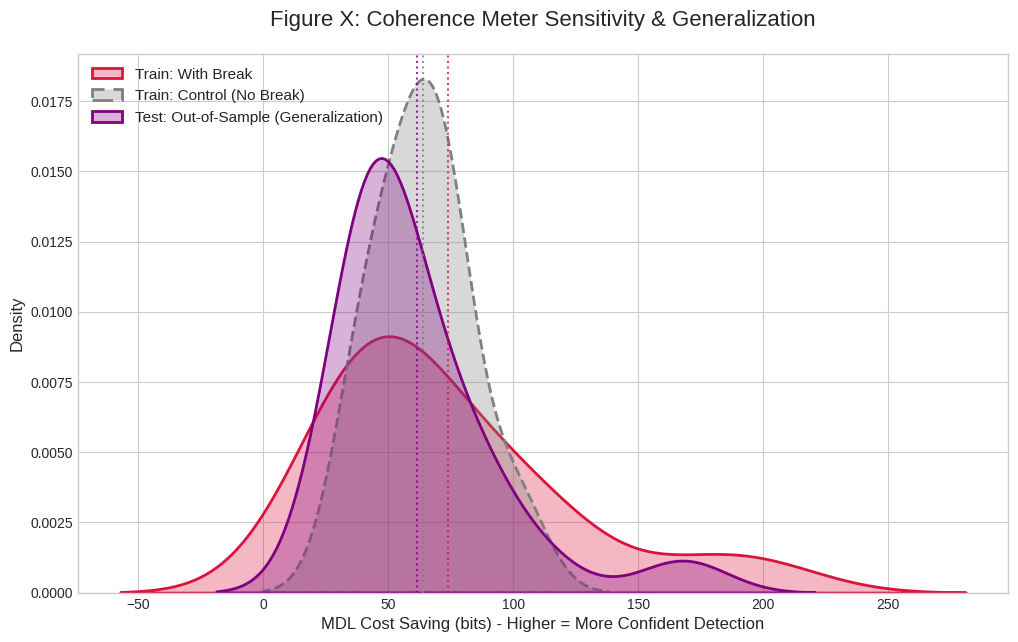


Table X: Summary Statistics for Systematic Validation
               Metric  Train (Break)  Train (Control)  Test (Generalization)
Mean MDL Score (bits)          73.88            63.88                  61.57
     Median MDL Score          61.13            63.82                  49.03
              Std Dev          48.26            19.22                  32.01
           % Positive         100.00           100.00                 100.00


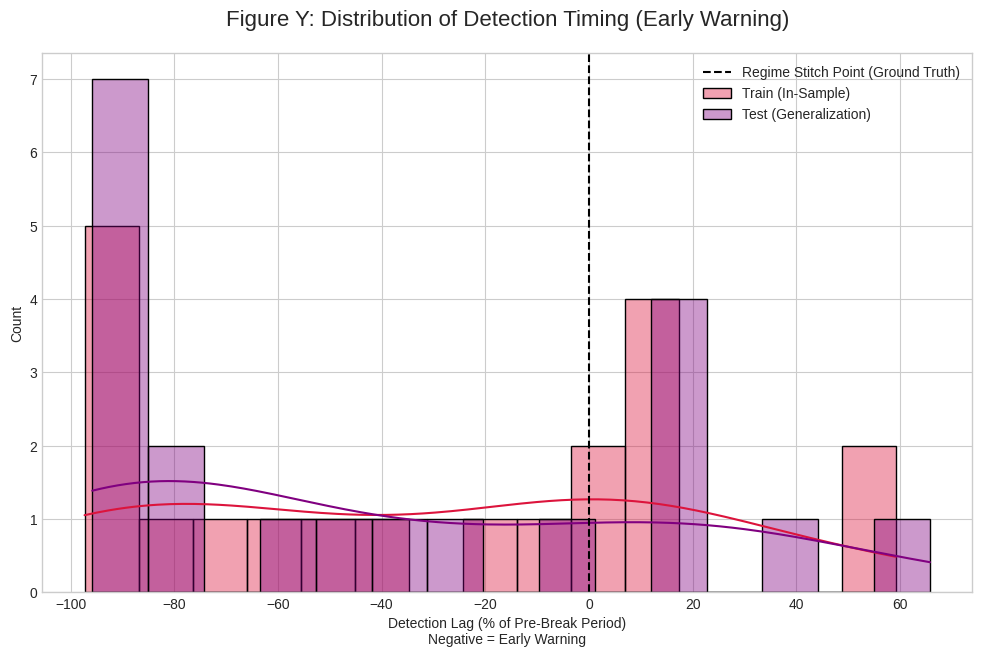


Table Y: Summary Statistics for Detection Timing
        Metric Train (In-Sample) Test (Generalization)
  Mean Lag (%)           -31.21%               -39.37%
Median Lag (%)           -25.78%               -51.69%
   Std Dev (%)            51.26%                53.38%


In [12]:
# @title Cell 6: Analysis and Visualization (Sensitivity & Generalization)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Data Segmentation ---
train_break = results_df[(results_df['set'] == 'Train') & (results_df['type'] == 'Break')].copy()
train_control = results_df[(results_df['set'] == 'Train') & (results_df['type'] == 'Control')].copy()
test_break = results_df[(results_df['set'] == 'Test') & (results_df['type'] == 'Break')].copy()

# --- 2. Figure X: Sensitivity & Generalization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot KDEs
sns.kdeplot(train_break['mdl_bits'], ax=ax, label='Train: With Break', color='crimson', fill=True, alpha=0.3, lw=2)
sns.kdeplot(train_control['mdl_bits'], ax=ax, label='Train: Control (No Break)', color='gray', fill=True, alpha=0.3, lw=2, linestyle='--')
sns.kdeplot(test_break['mdl_bits'], ax=ax, label='Test: Out-of-Sample (Generalization)', color='purple', fill=True, alpha=0.3, lw=2)

# Add Means
ax.axvline(train_break['mdl_bits'].mean(), color='crimson', linestyle=':', alpha=0.8)
ax.axvline(train_control['mdl_bits'].mean(), color='gray', linestyle=':', alpha=0.8)
ax.axvline(test_break['mdl_bits'].mean(), color='purple', linestyle=':', alpha=0.8)

ax.set_title('Figure X: Coherence Meter Sensitivity & Generalization', fontsize=16, pad=20)
ax.set_xlabel('MDL Cost Saving (bits) - Higher = More Confident Detection', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
plt.show()

# --- 3. Table X: Summary Statistics ---
summary_stats = {
    'Metric': ['Mean MDL Score (bits)', 'Median MDL Score', 'Std Dev', '% Positive'],
    'Train (Break)': [
        train_break['mdl_bits'].mean(),
        train_break['mdl_bits'].median(),
        train_break['mdl_bits'].std(),
        (train_break['mdl_bits'] > 0).mean() * 100
    ],
    'Train (Control)': [
        train_control['mdl_bits'].mean(),
        train_control['mdl_bits'].median(),
        train_control['mdl_bits'].std(),
        (train_control['mdl_bits'] > 0).mean() * 100
    ],
    'Test (Generalization)': [
        test_break['mdl_bits'].mean(),
        test_break['mdl_bits'].median(),
        test_break['mdl_bits'].std(),
        (test_break['mdl_bits'] > 0).mean() * 100
    ]
}
summary_df = pd.DataFrame(summary_stats)
print("\nTable X: Summary Statistics for Systematic Validation")
print(summary_df.to_string(index=False, float_format="%.2f"))


# --- 4. Early Warning Analysis (Lag) ---
# Now that gt_idx is the Stitch Point, these calcs will be finite and meaningful
for df in [train_break, test_break]:
    df['detection_lag'] = df['detected_break_idx'] - df['true_break_idx']
    # Pct of Pre-Break Period
    df['detection_lag_pct'] = (df['detection_lag'] / df['true_break_idx']) * 100

plt.figure(figsize=(12, 7))
sns.histplot(train_break['detection_lag_pct'], color='crimson', label='Train (In-Sample)', kde=True, alpha=0.4, bins=15)
sns.histplot(test_break['detection_lag_pct'], color='purple', label='Test (Generalization)', kde=True, alpha=0.4, bins=15)
plt.axvline(0, color='black', linestyle='--', label='Regime Stitch Point (Ground Truth)')
plt.title('Figure Y: Distribution of Detection Timing (Early Warning)', fontsize=16, pad=20)
plt.xlabel('Detection Lag (% of Pre-Break Period)\nNegative = Early Warning')
plt.legend()
plt.show()

# --- 5. Table Y: Lag Statistics ---
lag_stats = {
    'Metric': ['Mean Lag (%)', 'Median Lag (%)', 'Std Dev (%)'],
    'Train (In-Sample)': [
        f"{train_break['detection_lag_pct'].mean():.2f}%",
        f"{train_break['detection_lag_pct'].median():.2f}%",
        f"{train_break['detection_lag_pct'].std():.2f}%"
    ],
    'Test (Generalization)': [
        f"{test_break['detection_lag_pct'].mean():.2f}%",
        f"{test_break['detection_lag_pct'].median():.2f}%",
        f"{test_break['detection_lag_pct'].std():.2f}%"
    ]
}
lag_df = pd.DataFrame(lag_stats)
print("\nTable Y: Summary Statistics for Detection Timing")
print(lag_df.to_string(index=False))

---